In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
from src.data_processing import process_file, compute_physical, process_file_from_wizard, split_experiments

folder_path = "data/Test_XH430W350_20240209/PWM_control/*.csv"

# List to store each processed dataframe
processed_dataframes = []

# Iterate over all CSV files in the folder
for file_path in glob.glob(folder_path):
    # Apply processing function to the dataframe
    processed_df = process_file_from_wizard(file_path)
    experiments_split = split_experiments(processed_df)
    
    # Store the processed dataframe in the list
    processed_dataframes.extend(experiments_split)

external_inertia = 0.0022421143208 # Msolo
Ra = 9.3756 # [Ohm]
kt = 2.6657
ke = 0.8594

parameters = ke, kt, Ra, 0.080964165, 0.0665140867408596, 0.203719639, 0.04217117990939209, 0.0155818308

len(processed_dataframes)

119

In [2]:
import pickle

with open('dataframes_list.pkl', 'rb') as file:
    processed_dataframes = pickle.load(file)

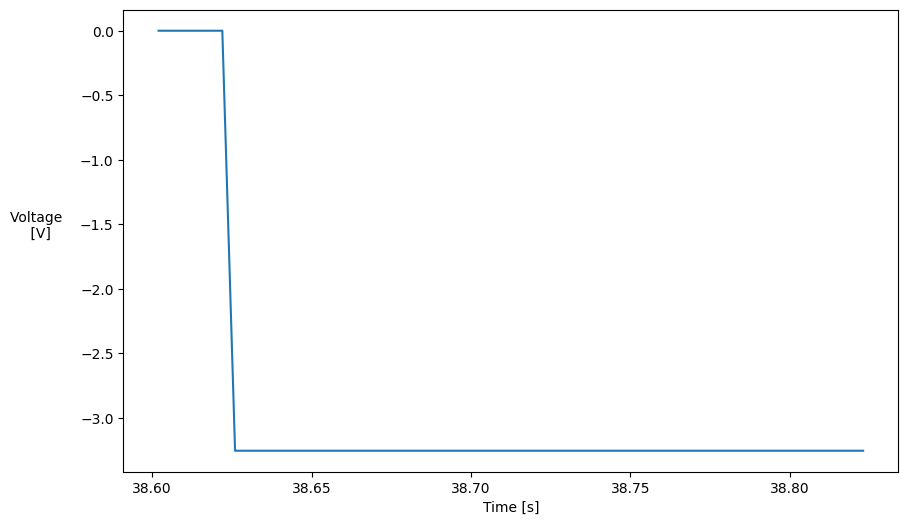

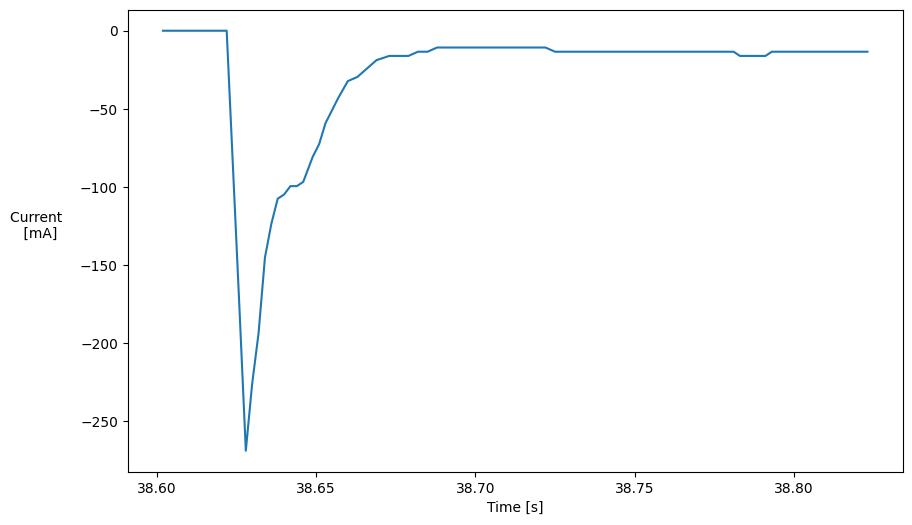

/var/folders/3b/gndgh3_j0mn3vgdx4cl1k6g00000gn/T/ipykernel_94305/1060116917.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_x'] = delta_x
/var/folders/3b/gndgh3_j0mn3vgdx4cl1k6g00000gn/T/ipykernel_94305/1060116917.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_t'] = delta_t
/var/folders/3b/gndgh3_j0mn3vgdx4cl1k6g00000gn/T/ipykernel_94305/1060116917.py:17: RuntimeWarning: invalid value encountered in divide
  df['Velocity_from_position'] = delta_x / delta_t
/var/folders/3b/gndg

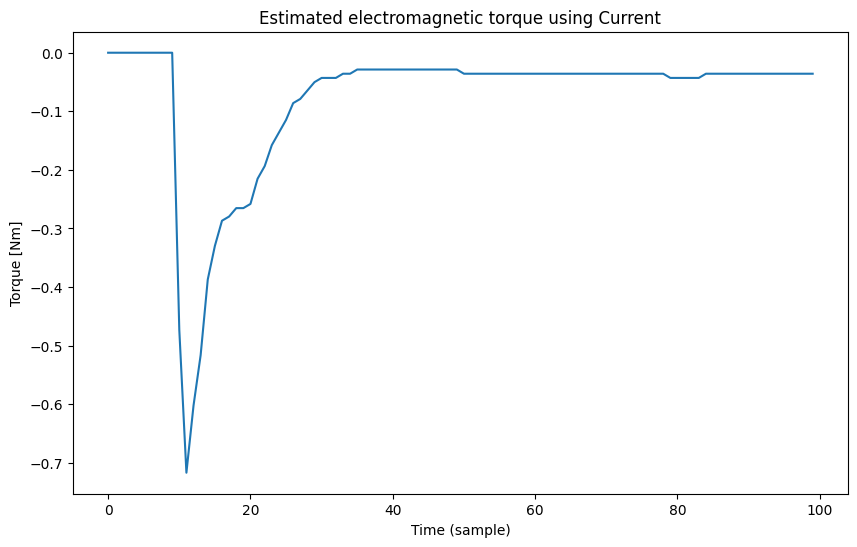

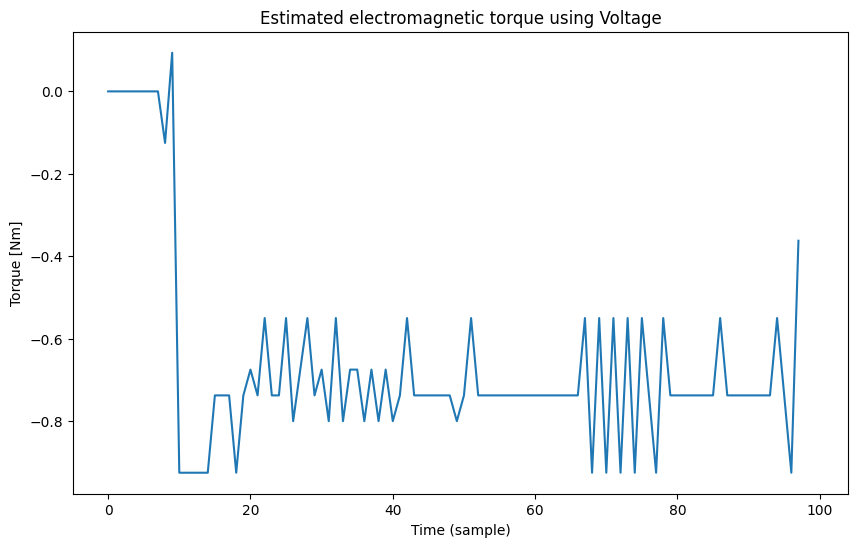

In [2]:
import numpy as np
from src.plotting import plot_data_q, plot_measured_U, plot_tau_o, plot_tau_f,plot_tau_I,plot_tau_U, plot_accelerations, plot_measured_q, plot_data_q_dot, plot_measured_I

df = processed_dataframes[7][:100]
plot_measured_U(df)
plot_measured_I(df)

delta_x = np.diff(df['DXL_Position'])
delta_x = np.insert(delta_x, len(delta_x)-1, 0)
df['delta_x'] = delta_x

delta_t = np.diff(df['t'])
delta_t = np.insert(delta_t, len(delta_t)-1, 0)
df['delta_t'] = delta_t

# Calculate velocity (Δx/Δt)
df['Velocity_from_position'] = delta_x / delta_t

df['tau_U'] = (kt / Ra) * (df['U'] - ke * df['Velocity_from_position'])
df['tau_I'] = df['DXL_Current'] * kt

plot_tau_I(df)
plot_tau_U(df)

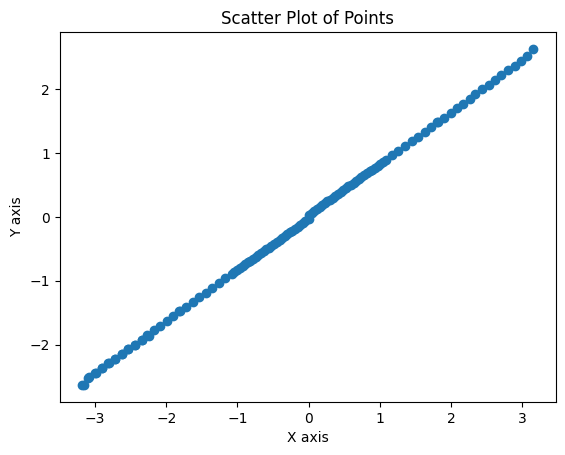

In [3]:
my_list = []
for df in processed_dataframes:
    df['tau_U'] = (kt / Ra) * (df['U'] - ke * df['DXL_Velocity'])
    my_list.append((df['DXL_Velocity'].mean(), df['tau_U'].mean()))
my_list

# Unzip the list of tuples into two lists
x_coords, y_coords = zip(*my_list)

# Create a scatter plot
plt.scatter(x_coords, y_coords)

# Add titles and labels
plt.title('Scatter Plot of Points')
plt.xlabel('X axis')
plt.ylabel('Y axis')

# Show the plot
plt.show()

In [4]:
from src.prediction import model_prediction_dynaban
from src.modelisation import friction_torque

for df in processed_dataframes:
    parameters_to_find = kt, Ra, 0.080964165, 0.0665140867408596, 0.203719639, 0.04217117990939209, 0.0155818308
    friction_torque(df, parameters_to_find)
    model_prediction_dynaban(df, parameters, external_inertia)
    plot_data_q(df)
    plot_data_q_dot(df)

KeyError: 'tau'

In [5]:
from src.modelisation import friction_torque
from src.prediction import model_prediction_dynaban

parameters_to_find = 0.080964165, 0.0665140867408596, 0.203719639, 0.04217117990939209, 0.0155818308
parameters_fixed = ke, kt, Ra
for df in processed_dataframes :
    q_dot_s, tau_c, tau_s, c_v, motor_inertia = parameters_to_find
    ke, kt, Ra = parameters_fixed
    parameters_friction = kt, 0, q_dot_s, tau_c, tau_s, c_v, motor_inertia
    parameters_U = ke, kt, Ra, q_dot_s, tau_c, tau_s, c_v, motor_inertia
    friction_torque(df, parameters_friction)
    df['tau_U'] = (kt / Ra) * (df['U'] - ke * df['DXL_Velocity'])
    df['tau_I'] = df['DXL_Current'] * kt
    df['tau'] = df['tau_I']
    model_prediction_dynaban(df, motor_inertia, external_inertia)
    # errors += ((df['q_pred'] - df['DXL_Position']) ** 2).sum()


In [6]:
from src.objective_functions import model_error_on_list
from src.prediction import model_prediction_dynaban
parameters_to_find = 0.080964165, 0.0665140867408596, 0.203719639, 0.04217117990939209, 0.0155818308
parameters_fixed = ke, kt, Ra
model_error_on_list(processed_dataframes, parameters_to_find, parameters_fixed, external_inertia)

19815268322.0484

#### On split le problème en deux sous-problèmes :

1. Transient phase
2. Steady-state

#### 1. Transient phase

On estime l'acceleration réelle du système comme : 

$a_{réel}$ = (v_f - v_i) / $\Delta t$ 
où $\Delta t$ est donné par la durée durant laquelle le couple em est supérieur au couple de frottement,
donc $a = (\tau_{em} - \tau_f) / J$

On veut que $a_{réel} * \Delta t = a * \Delta t'$ où $\Delta t'$ est un vecteur.

In [14]:
from src.modelisation import output_torque_motor_with_I, output_torque_motor_with_U, friction_torque
from src.prediction import acc_prediction_dynaban
from src.objective_functions import compute_error_on_transient, compute_error_on_steady_state
import matplotlib.pyplot as plt
import numpy as np
Ra = 9.3756 # [Ohm]
kt = 2.6657
ke = 0.8594
ke = 3.75286
# ke = 3.62764
ke = 3.6103
external_inertia = 0.0022421143208 # Msolo

parameters_to_find = 0.080964165, 0.0665140867408596, 0.203719639, 0.04217117990939209, 0.0155818308
parameters_to_find = 0.12460979651121884, 1.6828569261486217e-07, 0.28473500620977843, 0.00404276701106158, 1.0155066637572764e-11
parameters_to_find = 0.01617036578492856, 0.015096861865557988, 0.2918129215634176, 0.003297682748334354, 0.06459834024599362
parameters_fixed = ke, kt, Ra

error = 0
taus = []
tau2 = []
comp = []
for df in processed_dataframes :
    q_dot_s, tau_c, tau_s, c_v, motor_inertia = parameters_to_find
    ke, kt, Ra = parameters_fixed
    parameters_friction = kt, 0, q_dot_s, tau_c, tau_s, c_v, motor_inertia
    parameters_U = ke, kt, Ra, q_dot_s, tau_c, tau_s, c_v, motor_inertia

    friction_torque(df, parameters_friction)
    output_torque_motor_with_U(df, parameters_U)
    output_torque_motor_with_I(df, parameters_friction)
    df['tau'] = df['tau_I']

    acc_prediction_dynaban(df, motor_inertia, external_inertia)

    # Step 1 : compute on transient
    # Estimation v_final
    q_i = df['DXL_Position'].iloc[0]
    q_f = df['DXL_Position'].iloc[-1]
    v_final = (q_f - q_i)/(df['t'].iloc[-1] - df['t'].iloc[0])

    # print(compute_error_on_transient(df[:100], v_final))
    error += compute_error_on_transient(df[:100], v_final)

    # # Step 2 : compute on steady-state
    # print(compute_error_on_steady_state(df[100:]))
    error += compute_error_on_steady_state(df[100:])
    # if abs(v_final) > 1.5:
    #     ke = 3.61
    # else :
    #     ke = 3.692371427546772 -0.3105417913664852*np.log(abs(v_final))
    df['tau'] = (kt / Ra) * (df['U'] - ke * v_final)
    df['tau'] = (kt / Ra) * (df['U'])
    # df['tau'] = (kt / Ra) * (df['U'] - ke * df['DXL_Velocity'])
    # df['tau'] = df['tau_I']
    
    # if abs(v_final) > 0.5 :
    #     df['tau'] = df['tau_I']
    
    df['I_from_U'] = (1 / Ra) * (df['U'] - ke * v_final)
    taus.append((v_final, df['tau'].mean()))
    comp.append([v_final, df['DXL_Current'][150:].mean(), df['I_from_U'][150:].mean()])
    tau2.append(df[100:])



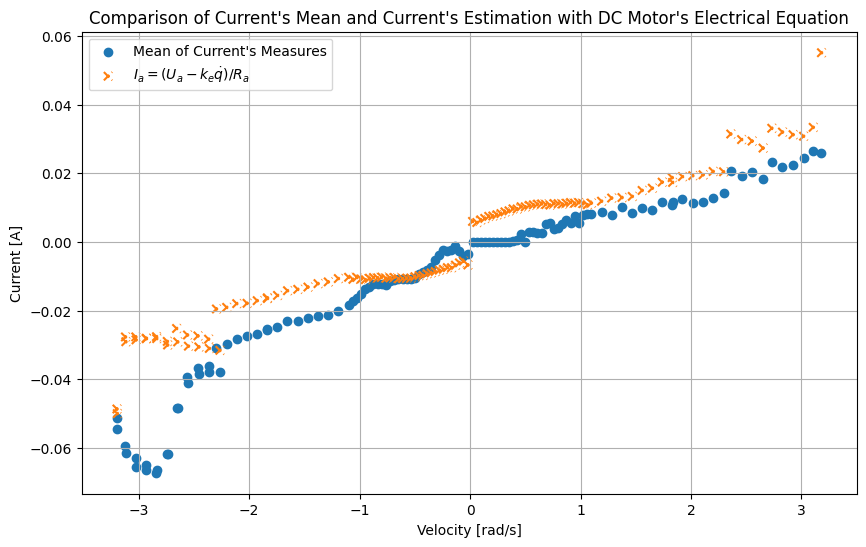

In [11]:
# Convert comp to a DataFrame for easier plotting
comp_df = pd.DataFrame(comp, columns=['v', 'DXL_Current_Mean', 'I_from_U_Mean'])

# Plotting
plt.figure(figsize=(10, 6))

# Plot DXL_Current_Mean
plt.scatter(comp_df['v'], comp_df['DXL_Current_Mean'], label="Mean of Current's Measures", marker='o', linestyle='-')

# Plot I_from_U_Mean
plt.scatter(comp_df['v'], comp_df['I_from_U_Mean'], label=r"$I_a = (U_a - k_e \dot{q})/R_a$", marker='x', linestyle='--')

# Adding labels and legend
plt.xlabel('Velocity [rad/s]')
plt.ylabel('Current [A]')
plt.title("Comparison of Current's Mean and Current's Estimation with DC Motor's Electrical Equation")
plt.legend()
plt.grid()
plt.show()

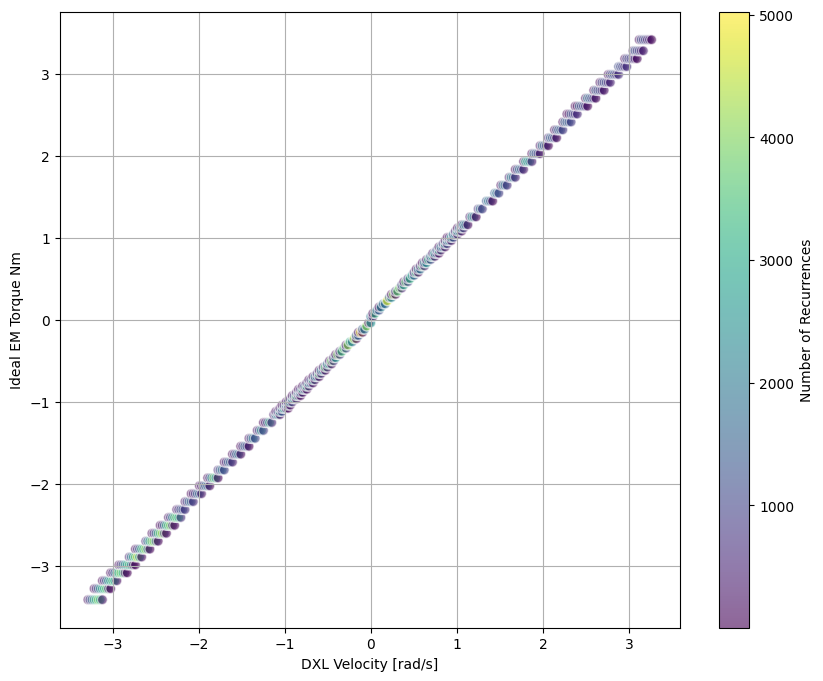

In [15]:
import pandas as pd
big_df = pd.concat(tau2, ignore_index=True)

# Group the data by 'DXL_Velocity', 'DXL_Current', and 'U' to find the recurrence
grouped = big_df.groupby(['DXL_Velocity', 'tau']).size().reset_index(name='counts')
# mean_R = grouped['R'].mean()

# Now let's create the scatter plot
plt.figure(figsize=(10, 8))
sc = plt.scatter(grouped['DXL_Velocity'], grouped['tau'], c=grouped['counts'], cmap='viridis', alpha=0.6, edgecolors='w', s=50)

# plt.axhline(y=mean_R, color='r', linestyle='-', label=f'Average Current: {mean_R:.2f}')
# Set the y-axis limits to zoom in between -0.1 and 0.1
# plt.ylim(-0.25, 0.1)
plt.grid()
plt.xlabel('DXL Velocity [rad/s]')
plt.ylabel('Ideal EM Torque Nm')
# plt.ylabel('kphi value [V.s/rad]')
cb = plt.colorbar(sc)
cb.set_label('Number of Recurrences')
# Adding the legend
# plt.legend()
plt.show()

/var/folders/3b/gndgh3_j0mn3vgdx4cl1k6g00000gn/T/ipykernel_81490/4118268691.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tau'] = (kt / Ra) * (df['U'] - ke * v_final)


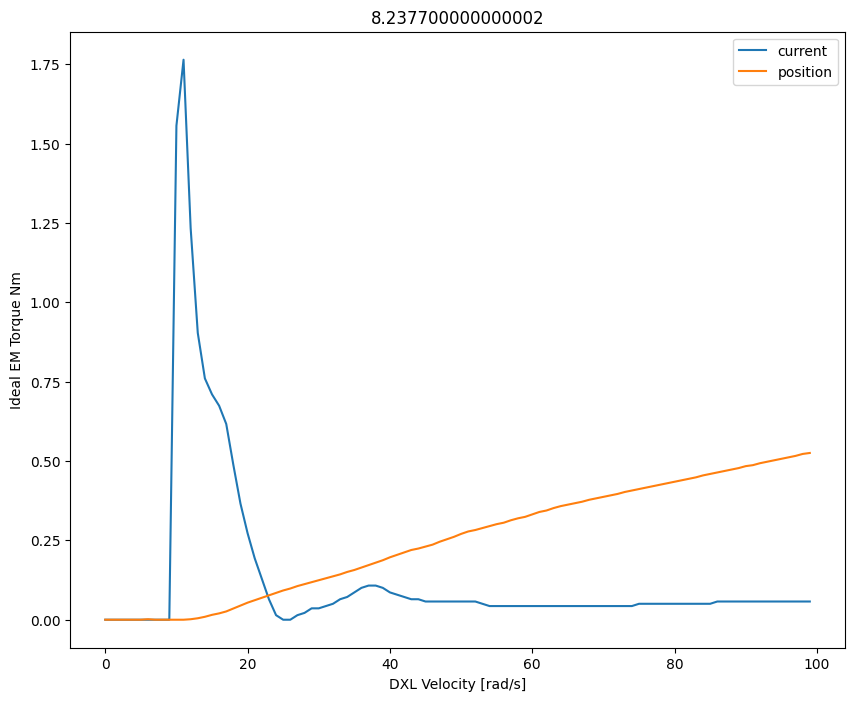

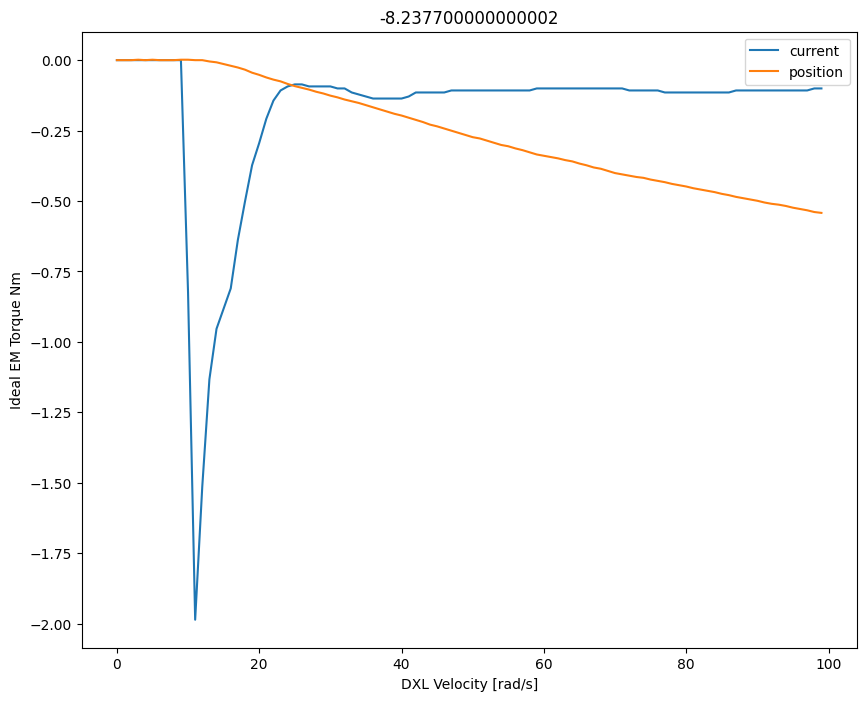

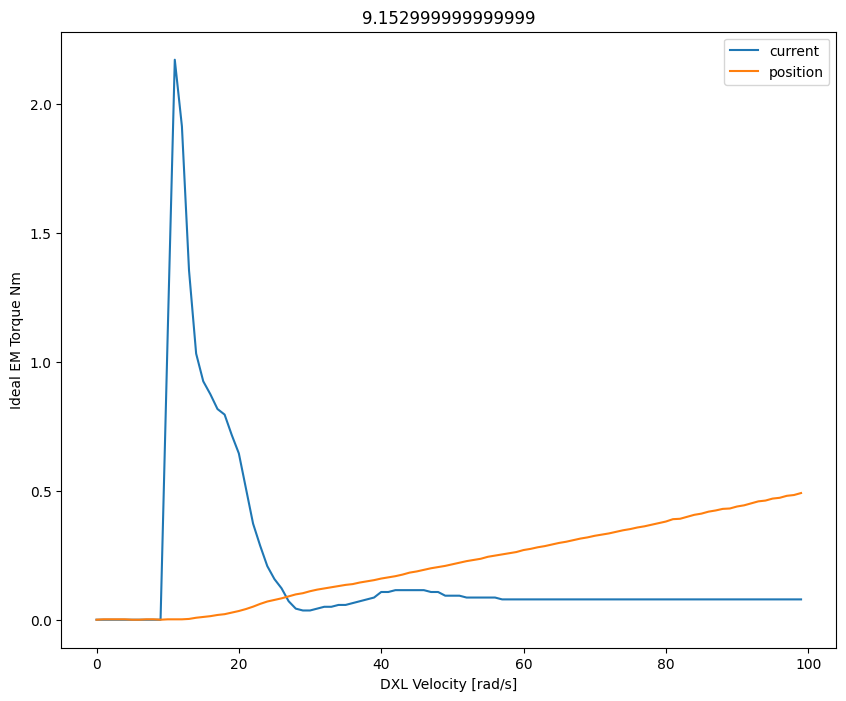

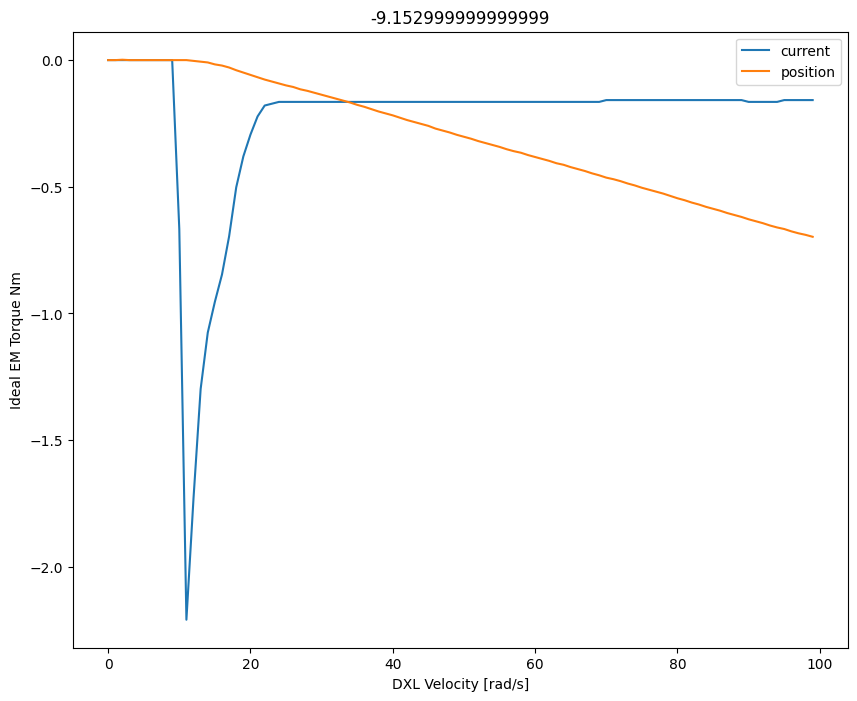

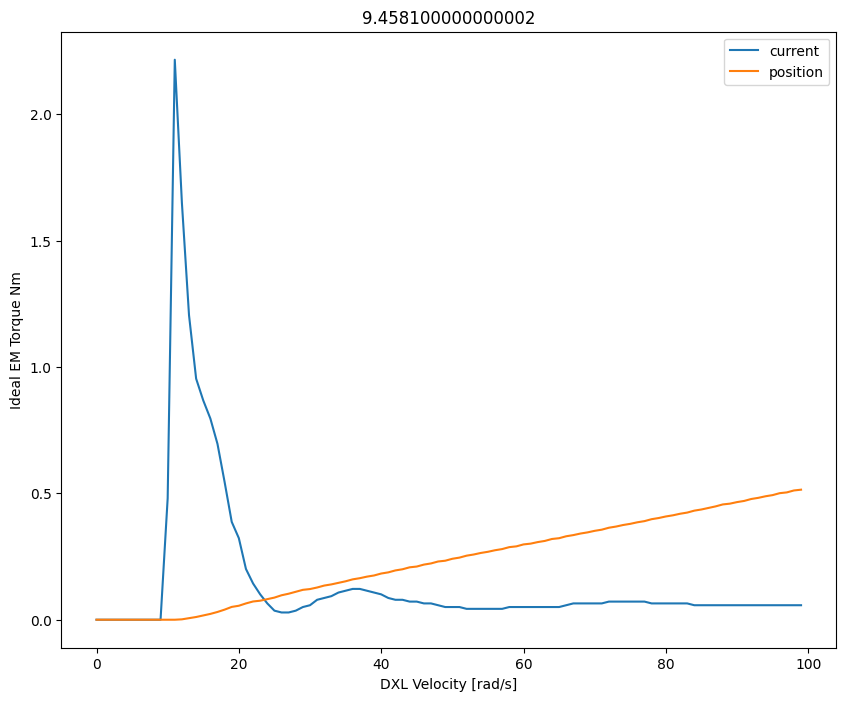

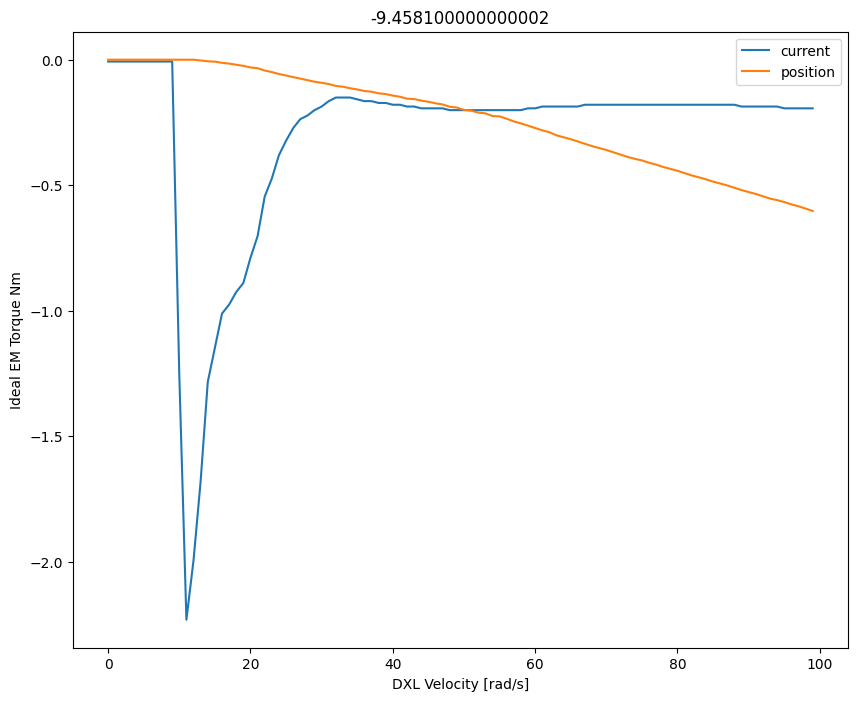

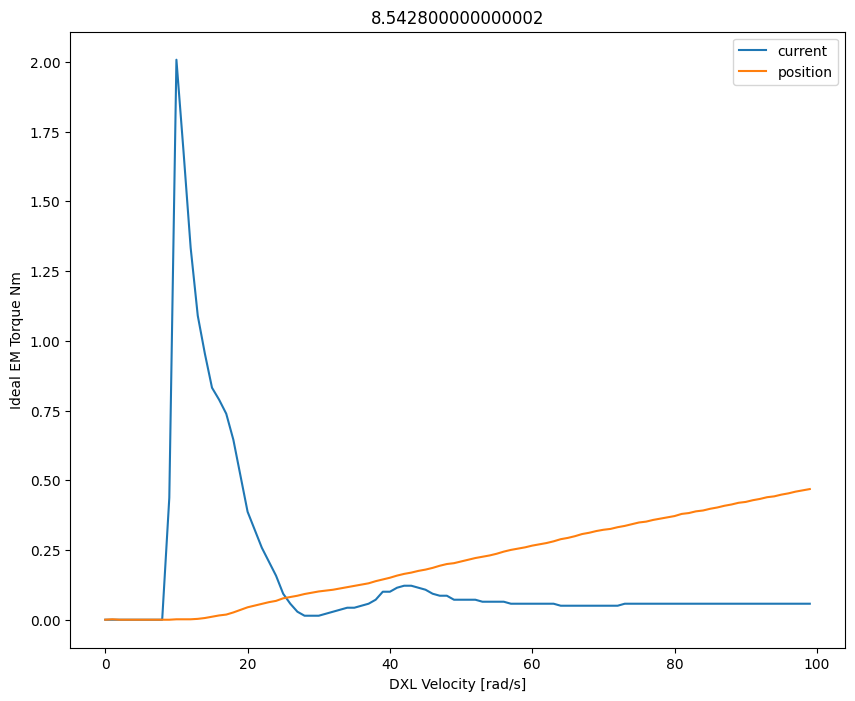

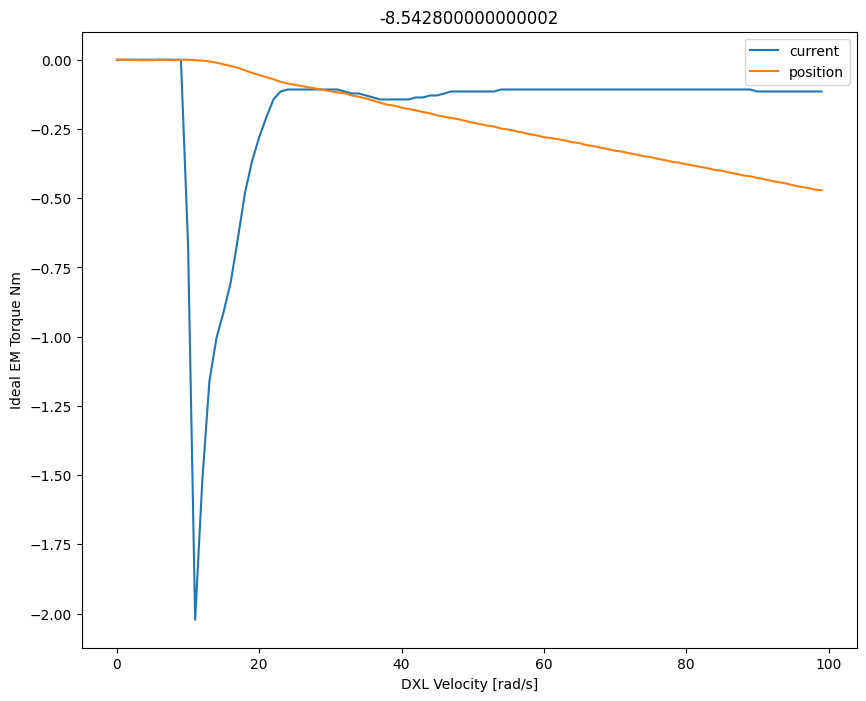

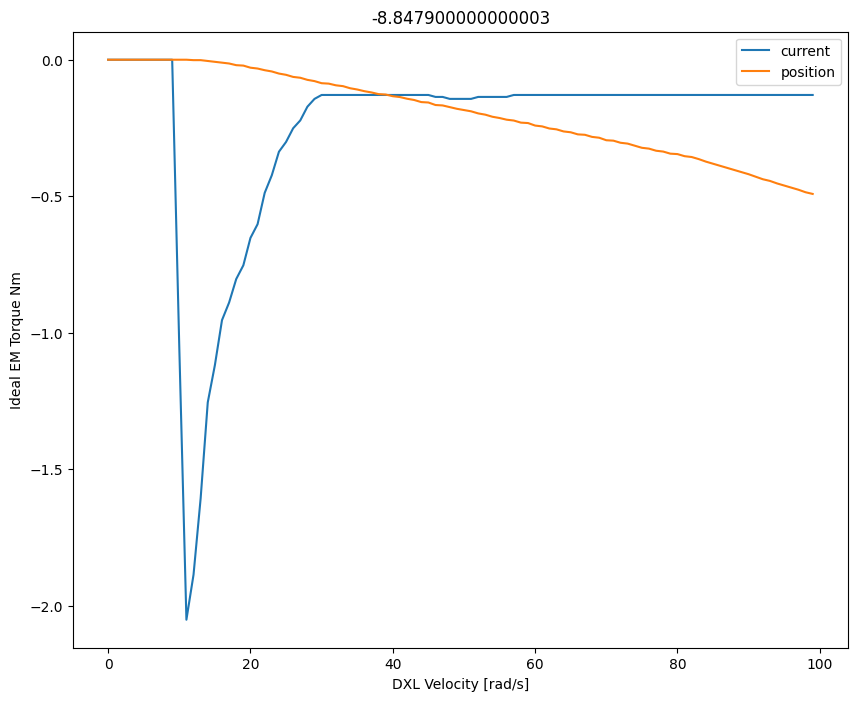

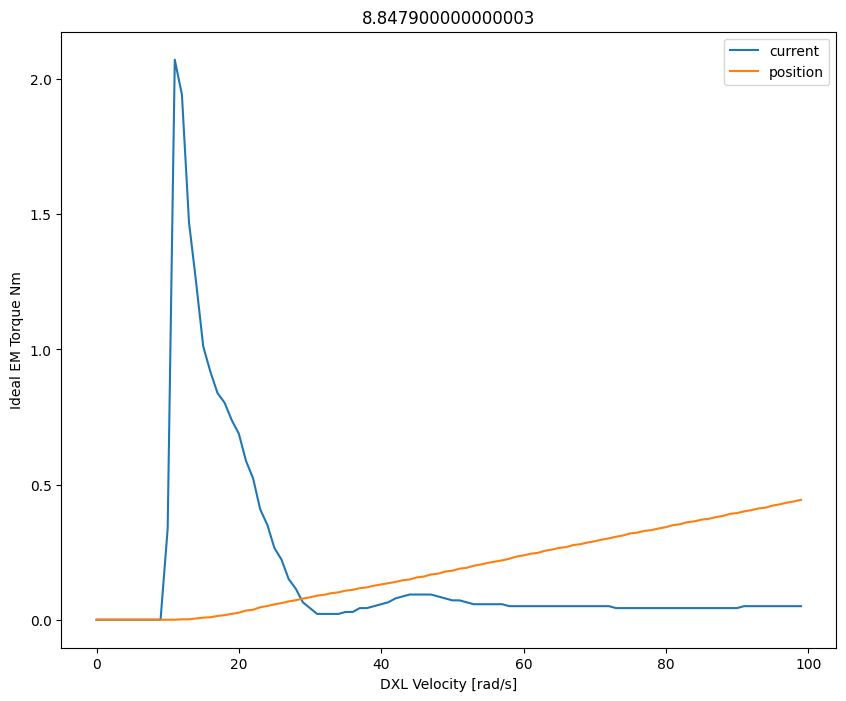

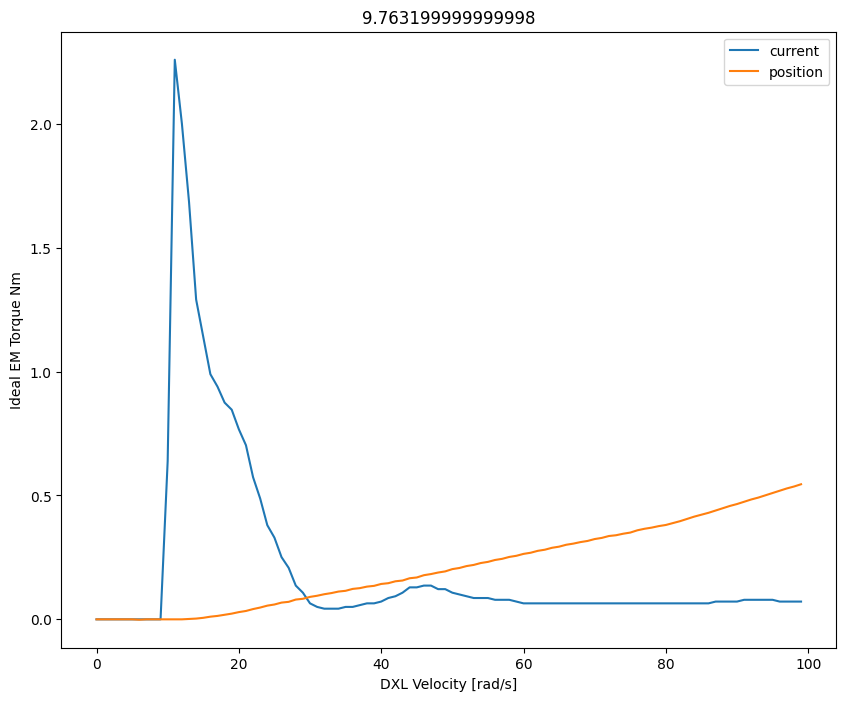

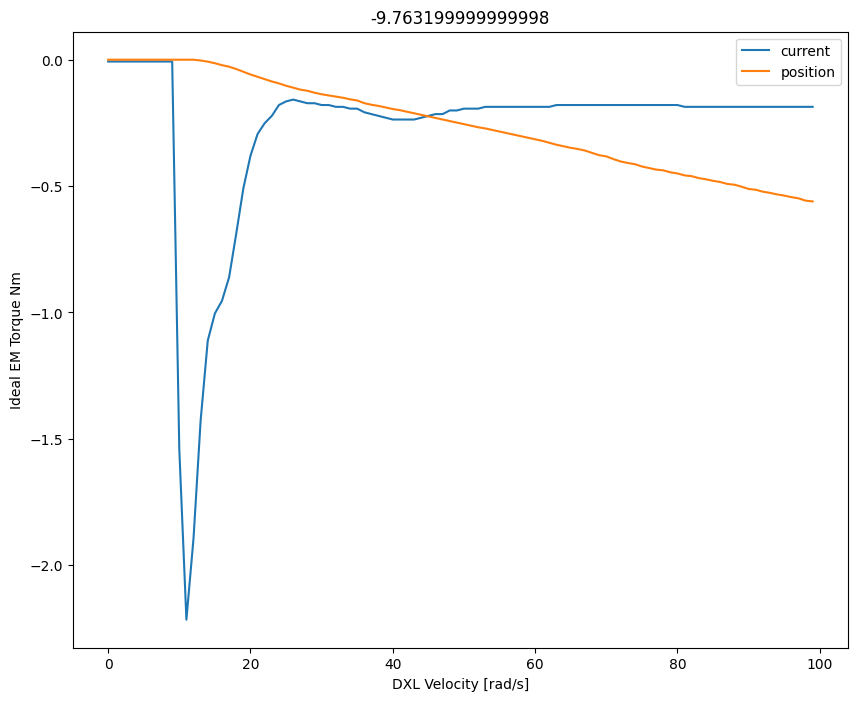

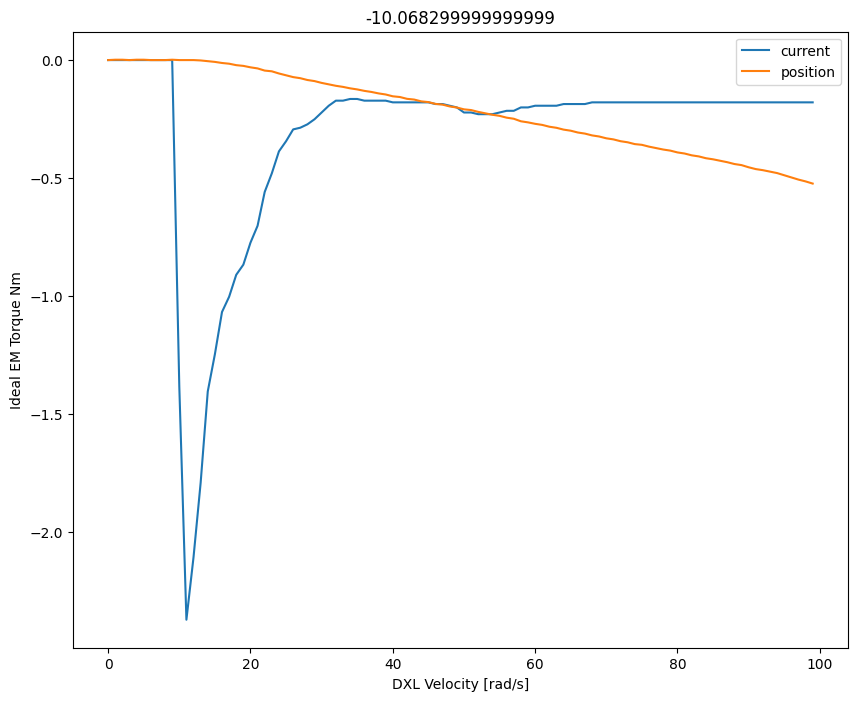

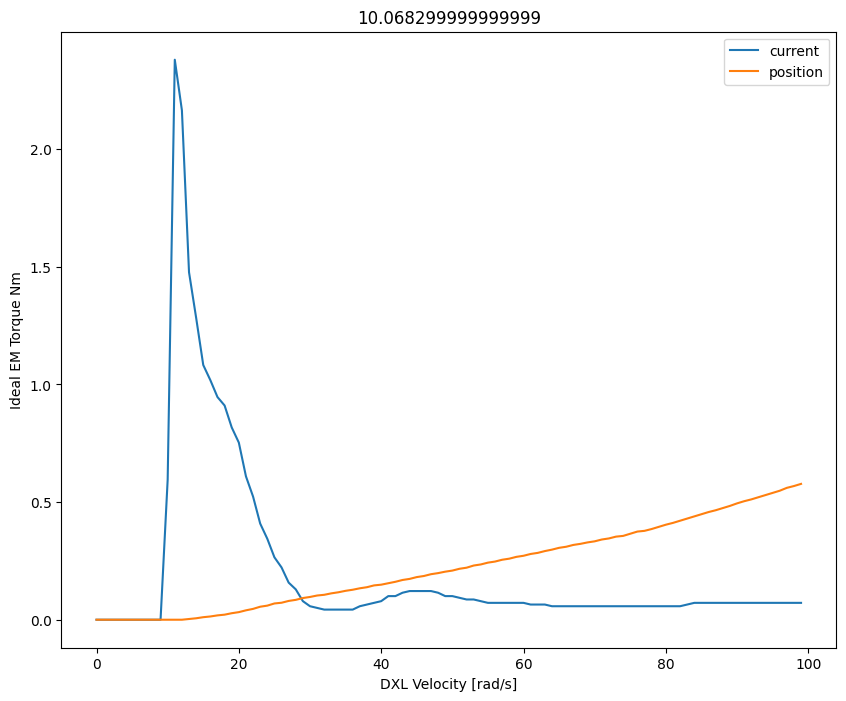

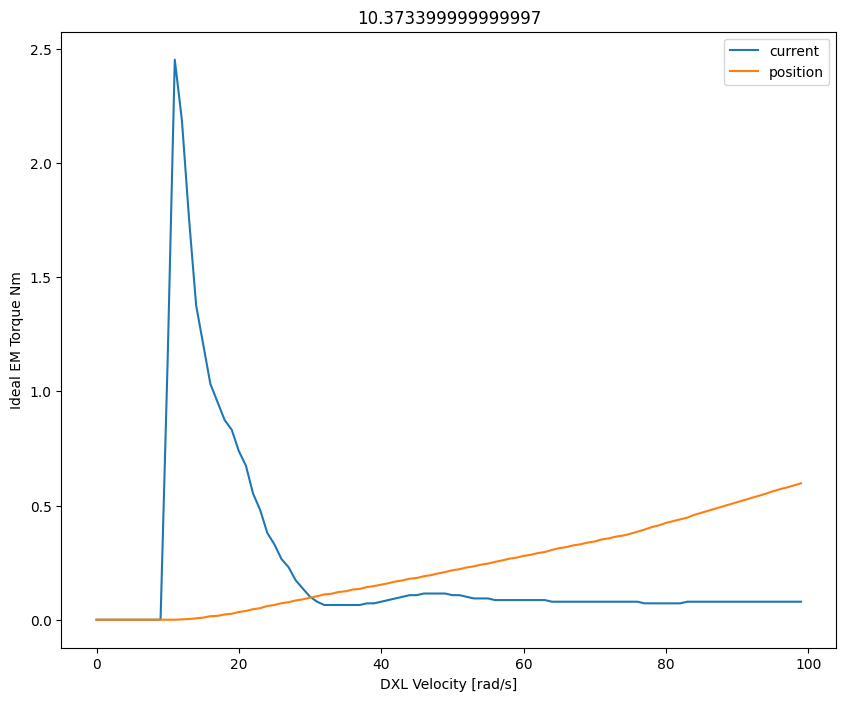

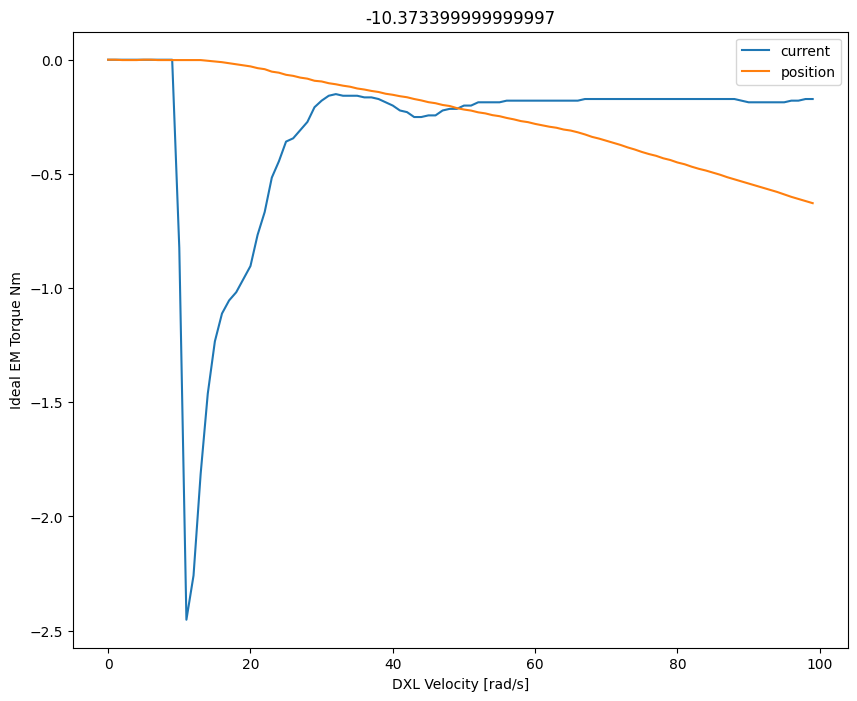

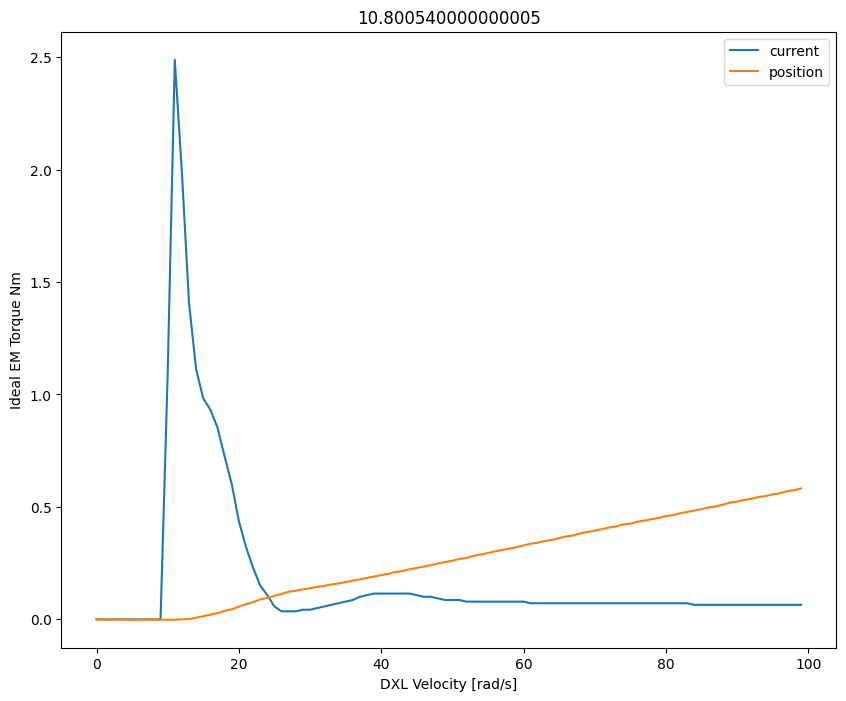

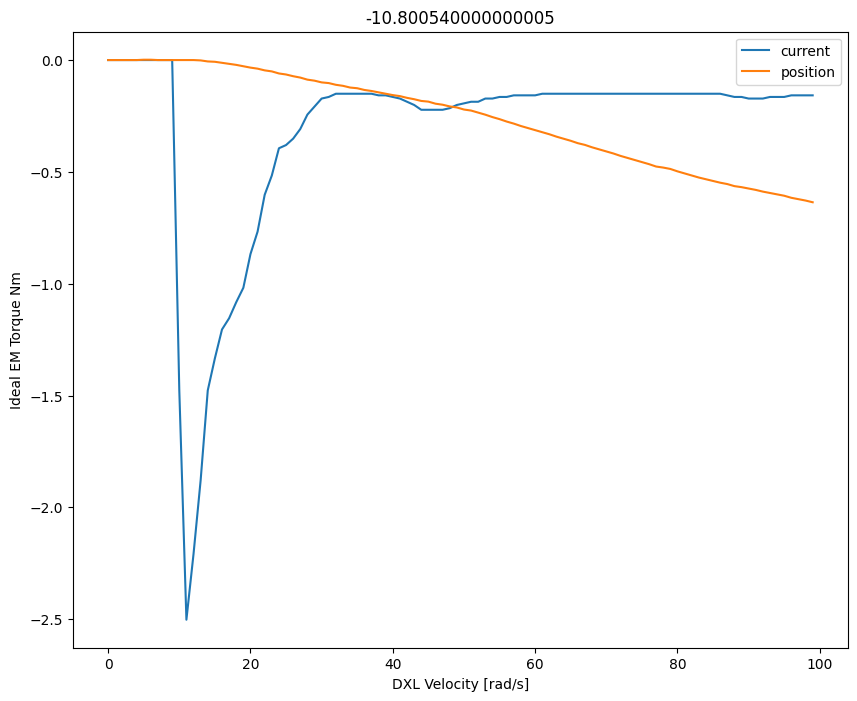

In [133]:
count = 0
for df in tau2:
    df = df[:100]
    # if count < 30:
    if abs(df['U'].mean()) > 8:
        plt.figure(figsize=(10, 8))
        # plt.plot(df['a'], label='acc')
        plt.plot(df['DXL_Current']*kt, label='current')
        q_i = df['DXL_Position'].iloc[0]
        q_f = df['DXL_Position'].iloc[-1]
        v_final = (q_f - q_i)/(df['t'].iloc[-1] - df['t'].iloc[0])
        df['tau'] = (kt / Ra) * (df['U'] - ke * v_final)

        # plt.plot(df['tau'], label='voltage')
        plt.plot(df['DXL_Position']-df['DXL_Position'].iloc[0], label='position')
        plt.xlabel('DXL Velocity [rad/s]')
        plt.ylabel('Ideal EM Torque Nm')
        plt.title(df['U'].mean())
        # Adding the legend
        plt.legend()
        plt.show()
    count+=1


In [4]:
# Unzip the list of tuples into two lists
x_coords, y_coords = zip(*taus)

# Create a scatter plot
plt.scatter(x_coords, y_coords)

points = 0.0004125317819209018 + 0.0043450040003781215
# plt.plot(x_coords, 0.0004125317819209018 + 0.0043450040003781215 * y_coords)
# Add titles and labels
plt.title('Scatter Plot of Points')
plt.xlabel('X axis')
plt.ylabel('Y axis')

# Show the plot
plt.show()

ValueError: not enough values to unpack (expected 2, got 0)

#### 2. Steady-state

On veut durant cette phase, que le couple electromagnétique soit toujours égal au couple de frottement -> pas d'accélerations ou de décélération durant cette phase

In [ ]:
q_dot_s, tau_c, tau_s, c_v, motor_inertia
[0.00615040155125402, 1.3252862858085793e-10, 0.27051204230135073, 4.69511837796772e-12, 0.0018150960027097345]

